<a href="https://colab.research.google.com/github/akshaykoul-bit/tfx-kubeflow/blob/tfrecommender/kubeflow_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install kubeflow

In [ ]:
# KFP
!pip install --upgrade kfp

# Import libraries

In [ ]:
import kfp
from kfp.v2 import dsl
from kfp.v2.dsl import component
from kfp.v2.dsl import (
    Input,
    InputPath,
    Output,
    Artifact,
    Dataset,
    Model,
    Metrics
)

# **Download data from tfds and select features of interest**

In [ ]:
@component(
    packages_to_install=["tensorflow","tensorflow-datasets"],
    output_component_file="download_data_component.yaml"
)
def download_data(ratingstf_url:str,moviestf_url:str, output_ratingstf: Output[Artifact],output_moviestf: Output[Artifact]):

  import tensorflow as tf
  import tensorflow_datasets as tfds

  ratingstf = tfds.load(f'{ratingstf_url}', split="train")
  moviestf = tfds.load(f'{moviestf_url}', split="train")

  # select main features of interest
  ratingstf = ratingstf.map(lambda x: {
      "movie_title": x["movie_title"],
      "user_id": x["user_id"],
      "user_rating": x["user_rating"],
  })
  moviestf = moviestf.map(lambda x: x["movie_title"])

  tf.data.experimental.save(ratingstf, output_ratingstf.path)
  tf.data.experimental.save(moviestf, output_moviestf.path)


## **Split Data into train and test and create unique movie ids and titles artifact**

In [ ]:
@component(
    packages_to_install=["tensorflow","tensorflow-datasets","numpy"],
    output_component_file="split_data_component.yaml"
)
def split_data(input_ratingstf:Input[Artifact], input_moviestf: Input[Artifact],output_train: Output[Artifact],output_test: Output[Artifact],
                  output_uq_movttls: Output[Artifact],output_uq_usids: Output[Artifact]):
  
  import numpy as np
  import tensorflow as tf
  import tensorflow_datasets as tfds
  import pickle

  ratingstf = tf.data.experimental.load(input_ratingstf.path)
  moviestf = tf.data.experimental.load(input_moviestf.path)

  tf.random.set_seed(11)
  shuffled = ratingstf.shuffle(100_000, seed=11, reshuffle_each_iteration=False)

  train = shuffled.take(80_000)
  test = shuffled.skip(80_000).take(20_000)

  movie_titles = moviestf.batch(1_000)
  user_ids = ratingstf.batch(1_000_000).map(lambda x: x["user_id"])

  unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
  unique_user_ids = np.unique(np.concatenate(list(user_ids)))

  tf.data.experimental.save(train, output_train.path)
  tf.data.experimental.save(test, output_test.path)
  with open(output_uq_movttls.path, "wb") as file:
    pickle.dump(unique_movie_titles, file)
  with open(output_uq_usids.path, "wb") as file:
    pickle.dump(unique_user_ids, file)
  # pickle.dump(movie_titles, output_uq_movttls.path)
  # pickle.dump(user_ids, output_uq_usids.path)

## **Build and train model**

In [ ]:
@component(
    packages_to_install=["tensorflow","tensorflow-recommenders","numpy"],
    output_component_file="build_and_train_model_component.yaml"
)
def build_and_train_model(input_moviestf:Input[Artifact],input_train:Input[Artifact], input_test: Input[Artifact],input_movie_titles:Input[Artifact], input_user_ids: Input[Artifact],output_metrics: Output[Artifact]):
  
  import numpy as np
  import tensorflow as tf
  import tensorflow_recommenders as tfrs
  import pickle
  from typing import Dict, Text

  moviestf = tf.data.experimental.load(input_moviestf.path)
  train = tf.data.experimental.load(input_train.path)
  test = tf.data.experimental.load(input_test.path)
  cached_train = train.shuffle(100_000).batch(8192).cache()
  cached_test = test.batch(4096).cache()
  # cached_train = train.shuffle(100_000).batch(8192)
  
  with open(input_movie_titles.path, "rb") as file:
    unique_movie_titles = pickle.load(file)
  with open(input_user_ids.path, "rb") as file:
    unique_user_ids = pickle.load(file)

  # unique_movie_titles = pickle.load(input_movie_titles.path)
  # unique_user_ids = pickle.load(input_user_ids.path)
  
  class MovielensModel(tfrs.models.Model):

    def __init__(self, rating_weight: float, retrieval_weight: float) -> None:
      super().__init__()

      embedding_dimension = 32

      # User and movie models.
      self.movie_model: tf.keras.layers.Layer = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
          vocabulary=unique_movie_titles, mask_token=None),
        tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
      ])
      self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
          vocabulary=unique_user_ids, mask_token=None),
        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
      ])

      self.rating_model = tf.keras.Sequential([
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(128, activation="relu"),
          tf.keras.layers.Dense(1),
      ])

      # The tasks.
      self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()],
      )
      self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
          metrics=tfrs.metrics.FactorizedTopK(
              candidates=moviestf.batch(128).map(self.movie_model)
          )
      )

      # The loss weights.
      self.rating_weight = rating_weight
      self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

      user_embeddings = self.user_model(features["user_id"])
      movie_embeddings = self.movie_model(features["movie_title"])

      return (
          user_embeddings,
          movie_embeddings,
          self.rating_model(
              tf.concat([user_embeddings, movie_embeddings], axis=1)
          ),
      )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

      ratings = features.pop("user_rating")

      user_embeddings, movie_embeddings, rating_predictions = self(features)

      # We compute the loss for each task.
      rating_loss = self.rating_task(
          labels=ratings,
          predictions=rating_predictions,
      )
      retrieval_loss = self.retrieval_task(user_embeddings, movie_embeddings)

      # And combine them using the loss weights.
      return (self.rating_weight * rating_loss
              + self.retrieval_weight * retrieval_loss)
    
  model = MovielensModel(rating_weight=1.0, retrieval_weight=1.0)
  model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
  history = model.fit(cached_train, epochs=3)
  # tf.saved_model.save(model, output_model.path)
  # tf.keras.models.save_model(model,output_model.path)
  # model.save(output_model.path)
  # with open(output_history.path, "wb") as file:
  #   pickle.dump(history.history, file)
    
  metrics = model.evaluate(cached_test, return_dict=True)
  with open(output_metrics.path, "wb") as file:
    pickle.dump(metrics, file)

  print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
  print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")
  # model.save(output_model.path)
    
  # pickle.dump(history.history, output_history.path)


## **Evaluate model metrics**

In [ ]:
@component(
    packages_to_install=["tensorflow","tensorflow-recommenders","numpy"],
    output_component_file="evaluate_model_component.yaml"
)
def evaluate_model_metrics(input_metrics: Input[Artifact], 
                   MLPipeline_Metrics: Output[Metrics]):  
  
  import pickle

  with open(input_metrics.path, "rb") as file:
      metrics = pickle.load(file)
    
  # vals = list(history.values())
  # print(vals)
  MLPipeline_Metrics.log_metric("Retrieval top-100 accuracy", metrics['factorized_top_k/top_100_categorical_accuracy'])
  MLPipeline_Metrics.log_metric("Ranking RMSE", metrics['root_mean_squared_error'])

## **Create pipeline**

In [ ]:
@dsl.pipeline(
    name="kfprec-pipeline",
)
def my_pipeline(ratingstf_url:str,moviestf_url:str):
    download_data_task = download_data(ratingstf_url=ratingstf_url,moviestf_url=moviestf_url)
    split_data_task = split_data(input_ratingstf=download_data_task.outputs['output_ratingstf'], input_moviestf=download_data_task.outputs['output_moviestf'])
    build_and_train_model_task = build_and_train_model(input_moviestf=download_data_task.outputs['output_moviestf'],input_train = split_data_task.outputs['output_train'], 
                                                       input_test = split_data_task.outputs['output_test'],input_movie_titles = split_data_task.outputs['output_uq_movttls'], 
                                                       input_user_ids = split_data_task.outputs['output_uq_usids'])
    # evaluate_model_task = evaluate_model(input_test = split_data_task.outputs['output_test'],input_model= build_and_train_model_task.outputs['output_model'], 
    #                                      input_history = build_and_train_model_task.outputs['output_history'])
    evaluate_model_task = evaluate_model_metrics(input_metrics = build_and_train_model_task.outputs['output_metrics'])

## **Compile pipeline**

In [ ]:
kfp.compiler.Compiler(mode=kfp.dsl.PipelineExecutionMode.V2_COMPATIBLE).compile(
    pipeline_func=my_pipeline,
    package_path='pipeline.yaml')

/usr/local/lib/python3.7/dist-packages/kfp/compiler/compiler.py:79: UserWarning: V2_COMPATIBLE execution mode is at Beta quality. Some pipeline features may not work as expected.
  warnings.warn('V2_COMPATIBLE execution mode is at Beta quality.'


## **Pipeline run (visualization)**

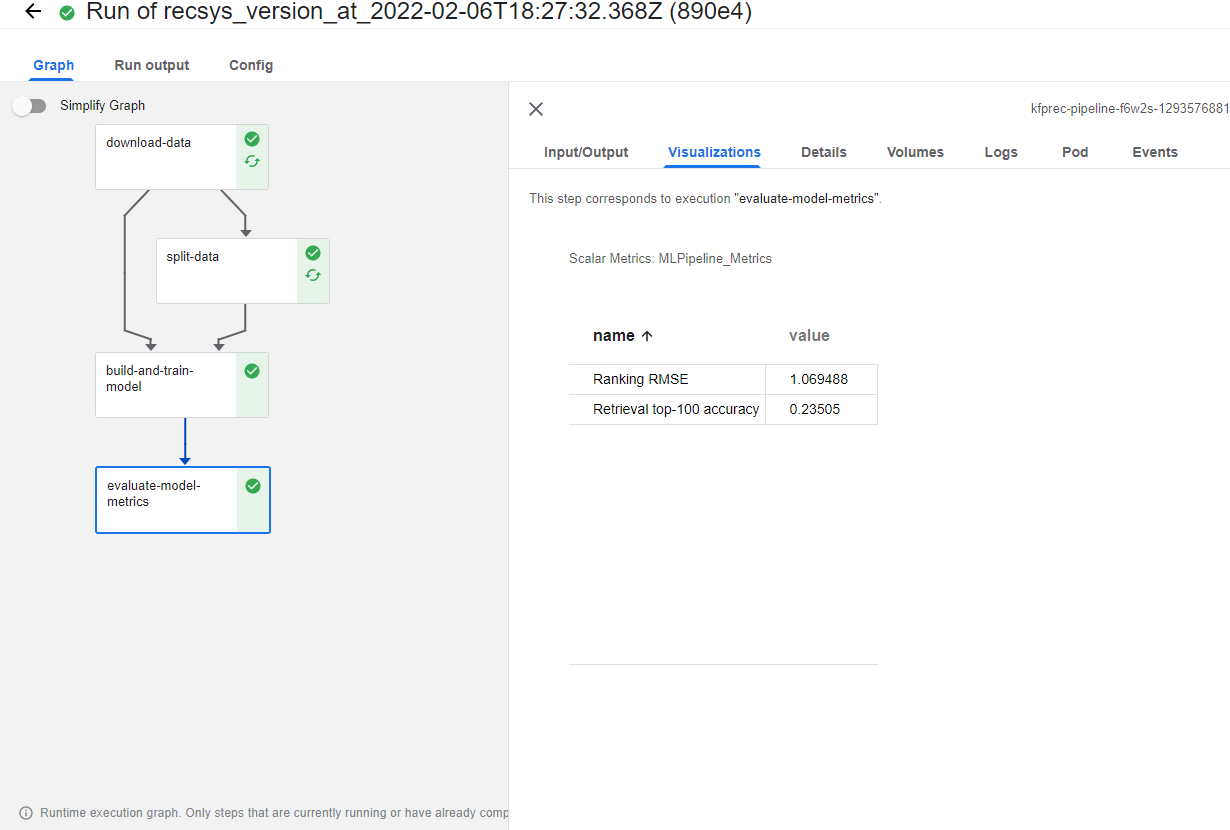